In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# קריאה הנתונים (TFRecord)

In [2]:
import tensorflow as tf
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.resize(image, (224, 224))
    label = parsed_example['label']
    return image, label

In [3]:
# פונקציה לטעינת ה-TFRecord כ-TensorFlow Dataset

In [4]:
def load_tfrecord_dataset(filenames):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    dataset = raw_dataset.map(parse_tfrecord)
    return list(dataset)  # המרה לרשימה לשימוש ישיר

In [5]:
# טעינת קבצי האימון והבדיקה

In [6]:
import os

# נתיב לתיקייה שבה נמצאים הקבצים
data_dir = r"C:\Users\revit\Documents\Data Learning\cars196"

# יצירת רשימת קבצי TFRecord עם הנתיב המלא
train_files = [os.path.join(data_dir, f"cars196-train.tfrecord-0000{i}-of-00008") for i in range(8)]
test_files = [os.path.join(data_dir, f"cars196-test.tfrecord-0000{i}-of-00008") for i in range(8)]


train_dataset = load_tfrecord_dataset(train_files)
test_dataset = load_tfrecord_dataset(test_files)

print(f"Loaded {len(train_dataset)} training images and {len(test_dataset)} test images.")

Loaded 8144 training images and 8041 test images.


# טעינת מודל ResNet50 לחישוב Embeddings

In [7]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

#  שלב 2: טעינת מודל ResNet50 לחילוץ מאפיינים
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model = torch.nn.Sequential(*list(model.children())[:-1])  # הסרת השכבה האחרונה
model.eval()

# 🔹 טרנספורמציה לתמונות
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image):
    """ממיר תמונה לפורמט Feature Vector"""
    image = transform(image).unsqueeze(0)  # הוספת ממד Batch
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

In [8]:
# יצירת אינדקס FAISS לאחסון הוקטורים
# כדי שנוכל לבצע חיפוש תמונות דומות, נשמור את וקטורי המאפיינים של כל התמונות במאגר FAISS.

In [9]:
import faiss
from PIL import Image

index = faiss.IndexFlatL2(2048)
all_features = []
image_data_list = []  # רשימה לשמירת המידע של התמונות

for i, (image, label) in enumerate(train_dataset):
    image_np = image.numpy().astype('float32') / 255.0  # הפיכת הטנסור ל-NumPy
    pil_image = Image.fromarray(np.uint8(image_np * 255))  # המרה ל-PIL
    feature_vector = extract_features(pil_image)  # חילוץ מאפיינים
    all_features.append(feature_vector)

    # 🔹 במקום לשמור נתיבים, שומרים את התמונה עצמה
    image_data_list.append((pil_image, label.numpy()))

# המרת הרשימות למערך FAISS
all_features = np.array(all_features).astype('float32')
index.add(all_features)

print(f"FAISS index built with {len(all_features)} images.")

FAISS index built with 8144 images.


In [10]:
#  פונקציה לבדיקה - Top-K Accuracy
def top_k_accuracy(query_label, matched_labels, k=5):
    """בודק כמה מתוך K התמונות הדומות ביותר תואמות לתווית של תמונת השאילתה"""
    correct_matches = sum(1 for label in matched_labels[:k] if label == query_label)
    return correct_matches / k  # מחזיר אחוז התאמה (0 עד 1)

#  פונקציה לחישוב Precision@K
def precision_at_k(query_label, matched_labels, k=5):
    """מחזירה את אחוז הדיוק בתוך K התמונות הראשונות"""
    relevant = sum(1 for label in matched_labels[:k] if label == query_label)
    return relevant / k  # ערך בין 0 ל-1

#  פונקציה לחישוב ממוצע הדיוק - mAP@K
def mean_average_precision(query_labels, matched_labels_list, k=5):
    """חישוב ממוצע ה-Precision@K עבור מספר תמונות שאילתה"""
    total_precision = 0.0
    for i in range(len(query_labels)):
        total_precision += precision_at_k(query_labels[i], matched_labels_list[i], k)
    return total_precision / len(query_labels)  # ממוצע

In [11]:
# מציאת תמונות דומות

In [12]:
def search_similar(image, index, k=5):
    """מבצע חיפוש תמונות דומות באמצעות FAISS"""
    query_vector = extract_features(image).reshape(1, -1).astype('float32')
    distances, indices = index.search(query_vector, k)
    return indices[0]  # החזרת האינדקסים של התמונות הדומות

#  שלב 5: בחירת תמונת שאילתה
query_image, query_label = test_dataset[0]  # לוקחים תמונה לבדיקה
query_label = query_label.numpy()  # המרת הטנסור לערך מספרי
query_image_np = query_image.numpy().astype('float32') / 255.0
query_pil_image = Image.fromarray(np.uint8(query_image_np * 255))

# 🔹 ביצוע חיפוש
similar_images = search_similar(query_pil_image, index, k=5)

print("Similar photos where found in these indexes:", similar_images)

#  שלב 6: בדיקת התוויות של תמונת השאילתה והתמונות הדומות
matched_labels = [train_dataset[idx][1].numpy() for idx in similar_images]  # תוויות של התמונות הדומות

print("Query Image Label:", query_label)
print("Matched Labels:", matched_labels)

Similar photos where found in these indexes: [7636  286  592 2039 2714]
Query Image Label: 141
Matched Labels: [182, 25, 25, 182, 128]


In [13]:
# חישוב המדדים

In [14]:
#  חישוב המדדים:
accuracy = top_k_accuracy(query_label, matched_labels, k=5)
precision = precision_at_k(query_label, matched_labels, k=5)

print(f"Top-5 Accuracy: {accuracy:.2f}")
print(f"Precision@5: {precision:.2f}")

#  חישוב Mean Average Precision על 10 תמונות
query_labels = [test_dataset[i][1].numpy() for i in range(10)]
matched_labels_list = [[train_dataset[idx][1].numpy() for idx in search_similar(
    Image.fromarray(np.uint8(test_dataset[i][0].numpy() * 255)), index, k=5)] for i in range(10)]

mAP = mean_average_precision(query_labels, matched_labels_list, k=5)
print(f"Mean Average Precision (mAP@5): {mAP:.2f}")

Top-5 Accuracy: 0.00
Precision@5: 0.00
Mean Average Precision (mAP@5): 0.00


In [15]:
# הצגת תוצאות החיפוש

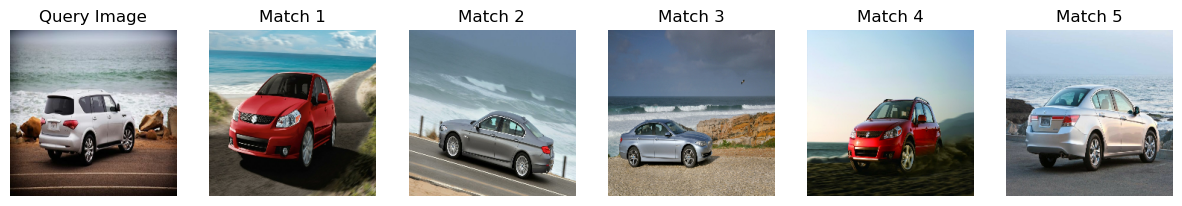

In [16]:
import matplotlib.pyplot as plt

def show_results(query_image, similar_indices):
    """מציג את תמונת השאילתה ואת התמונות הדומות ביותר"""
    fig, ax = plt.subplots(1, 6, figsize=(15, 5))
    
    # מציגים את תמונת השאילתה
    ax[0].imshow(query_image)
    ax[0].set_title("Query Image")
    ax[0].axis("off")

    # מציגים את 5 התמונות הדומות ביותר
    for i, idx in enumerate(similar_indices):
        if idx >= len(image_data_list):  # בדיקה שהאינדקס תקף
            print(f"Warning: FAISS returned invalid index {idx}. Skipping.")
            continue
        similar_pil_image, _ = image_data_list[idx]  
        ax[i+1].imshow(similar_pil_image)
        ax[i+1].set_title(f"Match {i+1}")
        ax[i+1].axis("off")

    plt.show()

# 🔹 הצגת התוצאות
show_results(query_pil_image, similar_images)